## FEATURES

* Tratamiento de outliers
* dataset mas grande (2000 datos)
* Mas variables (piscina, parrillero, año de construcción, etc.)

In [1]:
# imports

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
import pandas
from sklearn.metrics import mean_absolute_error

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
folder = '/content/drive/MyDrive/MaestriaDataScience/Tesis/FINAL_DATASET_CLEAN.xlsx'

In [4]:
import pandas as pd

data = pd.read_excel(folder)

In [5]:
data.head()

,Unnamed: 0,url,precio,Baños,Superficie,Superficie Construida,Superficie Terreno,Garage,Calefacción,Cocina,...,Plantas,Parrillero,Acepta Mascotas,Patio,Dormitorio,barrio,municipio,precio_por_m2_construido,precio_por_m2_terreno,precio_por_m2
0,0,https://www.casasymas.com.uy/propiedad/186603-...,675000,4.0,NaN,242,268,2,0,NaN,...,3.0,1,NaN,0,4.0,parque-batlle,CH,2789.256198,2518.656716,NaN
1,2,https://www.casasymas.com.uy/propiedad/212637-...,148000,2.0,131.0,98,131,1,0,Cocina Integrada,...,NaN,0,Acepta Mascotas,0,2.0,belvedere,A,1510.204082,1129.770992,1129.770992
2,3,https://www.casasymas.com.uy/propiedad/225135-...,625000,3.0,408.0,234,174,1,0,Cocina Definida,...,NaN,0,Acepta Mascotas,0,4.0,carrasco,E,2670.940171,3591.954023,1531.862745
3,4,https://www.casasymas.com.uy/propiedad/225720-...,580000,2.0,285.0,156,201,0,0,NaN,...,NaN,0,NaN,0,3.0,carrasco,E,3717.948718,2885.572139,2035.087719
4,6,https://www.casasymas.com.uy/propiedad/186448-...,670000,4.0,NaN,249,321,2,0,NaN,...,2.0,0,Acepta Mascotas,0,4.0,pocitos,CH,2690.763052,2087.227414,NaN


## OUTLIERS BARRIO

In [6]:
len(data)

1405

In [7]:
# Guardamos el dataset original ANTES de filtrar
data_original = data.copy()

def filtrar_outliers_barrio(g):
    if len(g) < 10:
        return g
    q1, q99 = g["precio"].quantile([0.01, 0.99])
    return g[g["precio"].between(q1, q99)]

df = data.groupby("barrio", group_keys=False).apply(filtrar_outliers_barrio)

df = df.reset_index(drop=True)

/tmp/ipython-input-4054932471.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = data.groupby("barrio", group_keys=False).apply(filtrar_outliers_barrio)


In [8]:
len(df)

1341

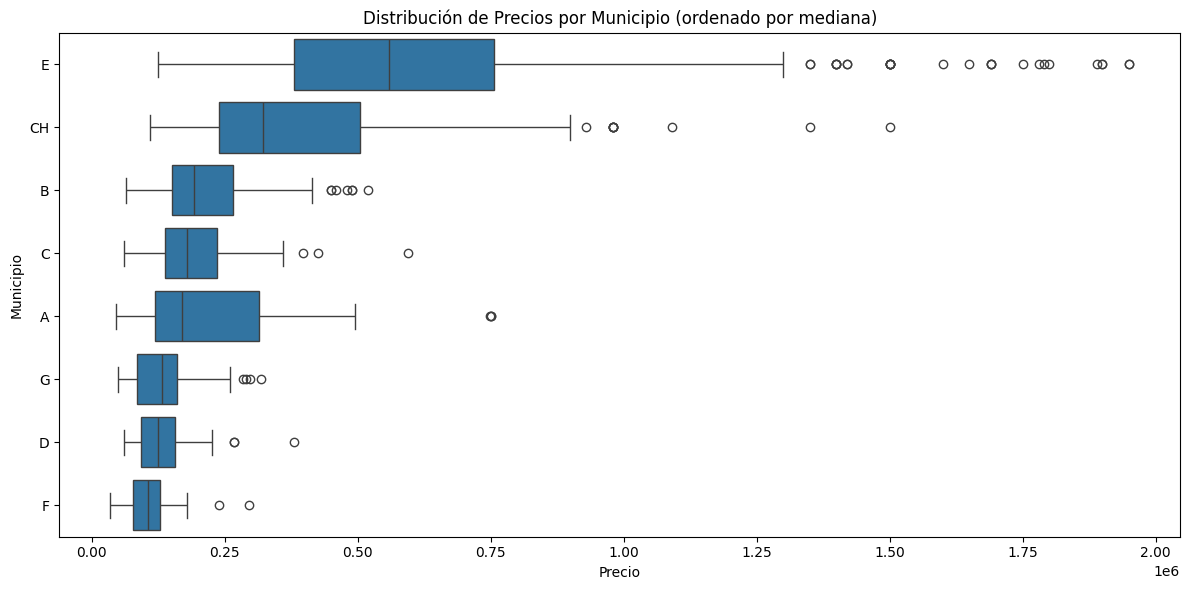

In [9]:
import seaborn as sns

orden_municipios = (df.groupby("municipio")["precio"].median().sort_values(ascending=False).index)

plt.figure(figsize=(12, 6))
sns.boxplot(
    x="precio",
    y="municipio",
    data=df,
    order=orden_municipios
)

plt.title("Distribución de Precios por Municipio (ordenado por mediana)")
plt.xlabel("Precio")
plt.ylabel("Municipio")

plt.tight_layout()
plt.show()

## Funciones Auxiliares

Para automatizar entrenamiento de modelos y ahorrar tiempo. Luego invocaremos las funciones para entrenar.

In [10]:
def split_data_log(df, features: list, target: list):
  X = features
  y = np.log(target)
  X = X.fillna(0)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  return X_train, X_test, y_train, y_test

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

def split_data_with_preprocessing(
    df,
    target: str,
    num_cols: list,
    cat_cols: list,
    test_size: float = 0.20,
    random_state: int = 42
):
    # Transformación logarítmica del target
    y = np.log(df[target])

    # Features sin target
    X = df[num_cols + cat_cols]

    # División simple: train vs test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Pipelines
    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])

    # Preprocesador combinado
    preprocess = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_cols),
            ("cat", categorical_transformer, cat_cols)
        ]
    )

    # Ajustar preprocess SOLO en training
    preprocess.fit(X_train)

    # Transformar datos
    X_train_prep = preprocess.transform(X_train)
    X_test_prep = preprocess.transform(X_test)

    return (
        X_train_prep, X_test_prep,
        y_train, y_test,
        preprocess,
        X_test.index
    )


In [12]:
def linear_regression_model(X_train, y_train):
  model_lr = LinearRegression()
  model_lr.fit(X_train, y_train)
  return model_lr

In [13]:
import lightgbm as lgb

def lightgbm_model(X_train, y_train, params=None):
    # Parámetros por defecto optimizados para MAE
    if params is None:
        params = {
            "objective": "l1",          # minimiza MAE
            "metric": "mae",           # evalúa usando MAE
            "learning_rate": 0.03,
            "num_leaves": 31,
            "feature_fraction": 0.9,
            "bagging_fraction": 0.8,
            "bagging_freq": 5
        }

    train_data = lgb.Dataset(X_train, label=y_train)

    model = lgb.train(
        params=params,
        train_set=train_data,
        num_boost_round=500
    )

    return model


In [14]:
from xgboost import XGBRegressor

def train_xgboost(X_train, y_train):
    model = XGBRegressor(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=4,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        reg_alpha=0.01,
        objective="reg:squarederror",
        random_state=42,
        tree_method="hist"
    )

    model.fit(X_train, y_train)
    return model


In [15]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

def train_xgboost_gridsearch(X_train, y_train, cv_folds=5, n_jobs=-1):

    # Param grid muy fuerte para MAE / MAPE
    param_grid = {
        "n_estimators": [600, 900, 1200],
        "learning_rate": [0.01, 0.03, 0.05],
        "max_depth": [3, 4, 5],
        "min_child_weight": [1, 3, 5],
        "subsample": [0.7, 0.85, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0],
        "reg_lambda": [1.0, 2.0, 5.0],
        "reg_alpha": [0, 0.01, 0.1]
    }

    xgb = XGBRegressor(
        objective="reg:squarederror",
        tree_method="hist",
        random_state=42
    )

    grid = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        scoring="neg_mean_absolute_error",  # optimizar MAE
        cv=cv_folds,
        verbose=1,
        n_jobs=n_jobs
    )

    grid.fit(X_train, y_train)

    print("\n======== MEJORES PARÁMETROS XGBOOST ========")
    print(grid.best_params_)
    print("\nMejor MAE (en log-space):", -grid.best_score_)
    print("=============================================\n")

    # Modelo final con los mejores hiperparámetros
    best_model = grid.best_estimator_

    return best_model


In [16]:
from sklearn.ensemble import RandomForestRegressor

def train_random_forest(X_train, y_train):
    rf = RandomForestRegressor(
        n_estimators=600,          # más árboles mejora MAE
        max_depth=20,              # evita overfitting, mantiene estabilidad
        min_samples_split=5,       # suaviza los árboles
        min_samples_leaf=2,        # controla extremos, mejora MAE
        max_features="sqrt",       # buen balance bias-variance
        bootstrap=True,            # robusto
        n_jobs=-1,
        random_state=42
    )

    rf.fit(X_train, y_train)
    return rf

In [17]:
def evaluate_model(model, X_test, y_test):
    y_test_pred_log = model.predict(X_test)

    y_test_pred_real = np.exp(y_test_pred_log)
    y_test_real = np.exp(y_test)

    mse_real = mean_squared_error(y_test_real, y_test_pred_real)
    r2_real = r2_score(y_test_real, y_test_pred_real)
    mae_real = mean_absolute_error(y_test_real, y_test_pred_real)
    medae_real = np.median(np.abs(y_test_real - y_test_pred_real))

    # MAPE — Mean Absolute Percentage Error
    mape = 100 * np.mean(np.abs((y_test_real - y_test_pred_real) / y_test_real))

    # MdAPE — Median Absolute Percentage Error
    mdape = 100 * np.median(np.abs((y_test_real - y_test_pred_real) / y_test_real))

    return mse_real, r2_real, mae_real, medae_real, mape, mdape

In [18]:
def evaluate_model(model, X_test, y_test):
    y_test_pred_log = model.predict(X_test)

    y_test_pred_real = np.exp(y_test_pred_log)
    y_test_real = np.exp(y_test)

    mse_real = mean_squared_error(y_test_real, y_test_pred_real)
    r2_real = r2_score(y_test_real, y_test_pred_real)
    mae_real = mean_absolute_error(y_test_real, y_test_pred_real)
    medae_real = np.median(np.abs(y_test_real - y_test_pred_real))

    # MAPE — Mean Absolute Percentage Error
    mape = 100 * np.mean(np.abs((y_test_real - y_test_pred_real) / y_test_real))

    # MdAPE — Median Absolute Percentage Error
    mdape = 100 * np.median(np.abs((y_test_real - y_test_pred_real) / y_test_real))

    return mse_real, r2_real, mae_real, medae_real, mape, mdape

In [19]:
def crear_tabla_resultados(nombres, mse_list, r2_list, mae_list, medae_list, mape_list, mdape_list):
    resultados = []

    for nombre, mse, r2, mae, medae, mape, mdape in zip(nombres, mse_list, r2_list, mae_list, medae_list, mape_list, mdape_list):
        resultados.append({
            "Modelo": nombre,
            "MAE": mae,
            "MEDAE": medae,
            "MSE": mse,
            "R2": r2,
            "MAPE": mape,
            "MDAPE": mdape
        })

    df_resultados = pd.DataFrame(resultados)
    pd.options.display.float_format = '{:,.2f}'.format
    return df_resultados


In [20]:
def evaluation_table(model, X_test_prep, y_test, df_original, extra_cols=None):

    # Predicción en log
    y_pred_log = model.predict(X_test_prep)

    # Convertir a precio real
    y_pred_real = np.exp(y_pred_log)
    y_test_real = np.exp(y_test)

    # Tabla base
    results = pd.DataFrame({
        "Precio Real": y_test_real,
        "Precio Predicho": y_pred_real,
    })

    results["Error Absoluto"] = np.abs(results["Precio Real"] - results["Precio Predicho"])
    results["Error %"] = 100 * results["Error Absoluto"] / results["Precio Real"]

    # Agregar columnas originales
    if extra_cols:
        df_extra = df_original.reset_index(drop=True)[extra_cols]
        results = pd.concat([results, df_extra], axis=1)

    return results.sort_values(by="Error %", ascending=False).reset_index(drop=True)


## Target y Features

In [21]:
features_simple = ["Baños", "Dormitorio", "Superficie", "Superficie Construida", "Superficie Terreno", "Garage", "Parrillero", "Calefacción", "Año de Construcción", "Jardín", "Piscina", "Patio"]



target = "precio"

## Train Test Splits

In [22]:
cat_cols = ["barrio", "municipio"]

(
    X_train_prep_all_municipios,
    X_test_prep_all_municipios,
    y_train_all_municipios,
    y_test_all_municipios,
    preprocess_all_municipios,
    test_indices_all_municipios
) = split_data_with_preprocessing(
        df=df,
        target=target,
        num_cols=features_simple,
        cat_cols=cat_cols,
        test_size=0.20,
        random_state=42
    )


In [23]:
data_ch = df[df["municipio"] == "CH"].copy()

cat_cols = ["barrio", "municipio"]

(
    X_train_prep_ch,
    X_test_prep_ch,
    y_train_ch,
    y_test_ch,
    preprocess_ch,
    test_indices_ch
) = split_data_with_preprocessing(
        df=data_ch,             # ← ahora solo CH
        target=target,
        num_cols=features_simple,
        cat_cols=cat_cols,      # podés incluir categóricas o dejarlas vacías
        test_size=0.20,
        random_state=42
    )


In [24]:
data_e = df[df["municipio"] == "E"].copy()

cat_cols = ["barrio", "municipio"]

(
    X_train_prep_e,
    X_test_prep_e,
    y_train_e,
    y_test_e,
    preprocess_e,
    test_indices_e
) = split_data_with_preprocessing(
        df=data_e,
        target=target,
        num_cols=features_simple,
        cat_cols=cat_cols,
        test_size=0.20,
        random_state=42
    )


## CHEQUEO INDICES

In [25]:
print("===== CHEQUEO DE CONSISTENCIA =====")

# 1. Chequeo de tamaño del df
print(f"Filas en df filtrado: {len(df)}")

# 2. Test indices generados
print(f"Test indices (cantidad): {len(test_indices_all_municipios)}")

# 3. Chequeo de valores extremos de test_indices
print(f"Primeros test indices: {list(test_indices_all_municipios[:10])}")
print(f"Últimos test indices: {list(test_indices_all_municipios[-10:])}")

# 4. Rango válido para indices
min_idx = min(test_indices_all_municipios)
max_idx = max(test_indices_all_municipios)
print(f"Rango de test_indices: {min_idx} → {max_idx}")

if max_idx >= len(df):
    print("\n❌ ERROR: test_indices_all_municipios contiene índices que NO existen en df.")
    print("   Esto ocurre si df no fue reseteado correctamente después del groupby().apply().")
else:
    print("\n✅ OK: Todos los índices del test existen en df.")

# 5. Chequeo de tamaños test coincidencia
print(f"\nTamaño X_test_prep_all_municipios: {X_test_prep_all_municipios.shape[0]}")
print(f"Tamaño y_test_all_municipios:      {len(y_test_all_municipios)}")
print(f"Tamaño test_indices:               {len(test_indices_all_municipios)}")

if (
    X_test_prep_all_municipios.shape[0] == len(y_test_all_municipios) == len(test_indices_all_municipios)
):
    print("\n✅ OK: Los tamaños de test coinciden.")
else:
    print("\n❌ ERROR: Los tamaños de test NO coinciden. Revisar split_data_with_preprocessing.")

print("\n===== FIN DEL CHEQUEO =====\n")


===== CHEQUEO DE CONSISTENCIA =====
Filas en df filtrado: 1341
Test indices (cantidad): 269
Primeros test indices: [802, 548, 570, 430, 259, 306, 1108, 503, 901, 711]
Últimos test indices: [712, 54, 377, 745, 109, 808, 680, 365, 842, 764]
Rango de test_indices: 23 → 1337

✅ OK: Todos los índices del test existen en df.

Tamaño X_test_prep_all_municipios: 269
Tamaño y_test_all_municipios:      269
Tamaño test_indices:               269

✅ OK: Los tamaños de test coinciden.

===== FIN DEL CHEQUEO =====



## Modelos

Entrenaremos modelos con features simples y features completas en todos los casos.

* Linear regression all_municipios
* RF municipio_ch
* RF municipio_e
* RF all_municipios
* RF Gridsearch municipio_ch
* RF Gridsearch municipio_e
* RF Gridsearch all_municipios

Nombres de modelos simples y completos:

* `model_lr_simple`, `model_lr`
* `rf_municipio_ch_simple`, `rf_municipio_ch`
* `rf_municipio_e_simple`, `rf_municipio_e`
* `rf_all_municipios_simple`, `rf_all_municipios`
* `rf_gridsearch_municipio_ch_simple`, `rf_gridsearch_municipio_ch`
* `rf_gridsearch_municipio_e_simple`, `rf_gridsearch_municipio_e`
* `rf_gridsearch_all_municipios_simple`, `rf_gridsearch_all_municipios`

## `xgb_simple`

In [26]:
xgb_simple = train_xgboost(
    X_train_prep_all_municipios,
    y_train_all_municipios
)


In [27]:
mse_xgb_simple, r2_xgb_simple, mae_xgb_simple, medae_xgb_simple, mape_xgb_simple, mdape_xgb_simple = evaluate_model(
    xgb_simple,
    X_test_prep_all_municipios,
    y_test_all_municipios
)

print(f"Mean Squared Error (MSE): {mse_xgb_simple}")
print(f"R² Score: {r2_xgb_simple}")
print(f"Mean Absolute Error (MAE): {mae_xgb_simple}")
print(f"Median Absolute Error (XGB): {medae_xgb_simple}")
print(f"MAPE (XGB): {mape_xgb_simple}")
print(f"Median Absolute Percentage Error (XGB): {mdape_xgb_simple}")


Mean Squared Error (MSE): 15027810406.374876
R² Score: 0.8556341759881553
Mean Absolute Error (MAE): 77158.28236814591
Median Absolute Error (XGB): 48369.875000000466
MAPE (XGB): 20.57898970963296
Median Absolute Percentage Error (XGB): 16.265480263157883


## `xgb_ch`

In [28]:
xgb_ch = train_xgboost(
    X_train_prep_ch,
    y_train_ch
)

print("XGBoost simple entrenado:", xgb_ch)

XGBoost simple entrenado: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=600,
             n_jobs=None, num_parallel_tree=None, ...)


In [29]:
mse_xgb_ch, r2_xgb_ch, mae_xgb_ch, medae_xgb_ch, mape_xgb_ch, mdape_xgb_ch = evaluate_model(
    xgb_ch,
    X_test_prep_ch,
    y_test_ch
)

print(f"Mean Squared Error (MSE): {mse_xgb_ch}")
print(f"R² Score: {r2_xgb_ch}")
print(f"Mean Absolute Error (MAE): {mae_xgb_ch}")
print(f"Median Absolute Error (XGB): {medae_xgb_ch}")
print(f"MAPE (XGB): {mape_xgb_ch}")
print(f"Median Absolute Percentage Error (XGB): {mdape_xgb_ch}")


Mean Squared Error (MSE): 10867073186.630836
R² Score: 0.785661127897171
Mean Absolute Error (MAE): 68664.87605168264
Median Absolute Error (XGB): 44475.50781250003
MAPE (XGB): 18.362585199002364
Median Absolute Percentage Error (XGB): 14.667982447240263


## `xgb_e`

In [30]:
xgb_e = train_xgboost(
    X_train_prep_e,
    y_train_e
)

print("XGBoost simple entrenado:", xgb_e)

XGBoost simple entrenado: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=600,
             n_jobs=None, num_parallel_tree=None, ...)


In [31]:
mse_xgb_e, r2_xgb_e, mae_xgb_e, medae_xgb_e, mape_xgb_e, mdape_xgb_e = evaluate_model(
    xgb_e,
    X_test_prep_e,
    y_test_e
)

print(f"Mean Squared Error (MSE): {mse_xgb_e}")
print(f"R² Score: {r2_xgb_e}")
print(f"Mean Absolute Error (MAE): {mae_xgb_e}")
print(f"Median Absolute Error (XGB): {medae_xgb_e}")
print(f"MAPE (XGB): {mape_xgb_e}")
print(f"Median Absolute Percentage Error (XGB): {mdape_xgb_e}")


Mean Squared Error (MSE): 20777910219.26438
R² Score: 0.8030020413573651
Mean Absolute Error (MAE): 98845.90197523589
Median Absolute Error (XGB): 62052.43750000003
MAPE (XGB): 15.38316227299513
Median Absolute Percentage Error (XGB): 10.627100852272727


## `model_lgbm_simple` (all municipios)

In [32]:
model_lgbm_simple = lightgbm_model(
    X_train_prep_all_municipios,
    y_train_all_municipios
)

print("Modelo LightGBM entrenado:", model_lgbm_simple)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 907
[LightGBM] [Info] Number of data points in the train set: 1072, number of used features: 33
[LightGBM] [Info] Start training from score 12.637856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [33]:
mse_lgbm_simple, r2_lgbm_simple, mae_lgbm_simple, medae_lgbm_simple, mape_lgbm_simple, mdape_lgbm_simple = evaluate_model(
    model_lgbm_simple,
    X_test_prep_all_municipios,
    y_test_all_municipios
)

print(f"Mean Squared Error (LGBM): {mse_lgbm_simple}")
print(f"R² Score (LGBM): {r2_lgbm_simple}")
print(f"Mean Absolute Error (LGBM): {mae_lgbm_simple}")
print(f"Median Absolute Error (LGBM): {medae_lgbm_simple}")
print(f"MAPE (LGBM): {mape_lgbm_simple}")
print(f"Median Absolute Percentage Error (LGBM): {mdape_lgbm_simple}")

Mean Squared Error (LGBM): 19228095059.074017
R² Score (LGBM): 0.8152838163167299
Mean Absolute Error (LGBM): 83276.22056452077
Median Absolute Error (LGBM): 46417.85075016436
MAPE (LGBM): 21.94913806769492
Median Absolute Percentage Error (LGBM): 16.035404969166365


## `lgbm_ch_simple`

In [34]:
# Modelo CH simple
lgbm_ch_simple = lightgbm_model(
    X_train_prep_ch,
    y_train_ch
)

print("Modelo LightGBM CH simple entrenado:", lgbm_ch_simple)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 237
[LightGBM] [Info] Number of data points in the train set: 207, number of used features: 15
[LightGBM] [Info] Start training from score 12.691581
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [35]:
mse_lgbm_ch_simple, r2_lgbm_ch_simple, mae_lgbm_ch_simple, medae_lgbm_ch_simple, mape_lgbm_ch_simple, mdape_lgbm_ch_simple = evaluate_model(
    lgbm_ch_simple,
    X_test_prep_ch,
    y_test_ch
)

print(f"Mean Squared Error (LGBM CH simple): {mse_lgbm_ch_simple}")
print(f"R² Score (LGBM CH simple): {r2_lgbm_ch_simple}")
print(f"Mean Absolute Error (LGBM CH simple): {mae_lgbm_ch_simple}")
print(f"Median Absolute Error (LGBM CH simple): {medae_lgbm_ch_simple}")
print(f"MAPE (LGBM CH simple): {mape_lgbm_ch_simple}")
print(f"Median Absolute Percentage Error (LGBM CH simple): {mdape_lgbm_ch_simple}")

Mean Squared Error (LGBM CH simple): 12680370036.488138
R² Score (LGBM CH simple): 0.7498962080414573
Mean Absolute Error (LGBM CH simple): 79645.80256568537
Median Absolute Error (LGBM CH simple): 54422.83661152674
MAPE (LGBM CH simple): 20.75689384615571
Median Absolute Percentage Error (LGBM CH simple): 18.41576327197003


## `lgbm_e_simple`

In [36]:
# Modelo E simple
lgbm_e_simple = lightgbm_model(
    X_train_prep_e,
    y_train_e
)

print("Modelo LightGBM E simple entrenado:", lgbm_e_simple)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 396
[LightGBM] [Info] Number of data points in the train set: 424, number of used features: 16
[LightGBM] [Info] Start training from score 13.199325
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [37]:
mse_lgbm_e_simple, r2_lgbm_e_simple, mae_lgbm_e_simple, medae_lgbm_e_simple, mape_lgbm_e_simple, mdape_lgbm_e_simple = evaluate_model(
    lgbm_e_simple,
    X_test_prep_e,
    y_test_e
)

print(f"Mean Squared Error (LGBM E simple): {mse_lgbm_e_simple}")
print(f"R² Score (LGBM E simple): {r2_lgbm_e_simple}")
print(f"Mean Absolute Error (LGBM E simple): {mae_lgbm_e_simple}")
print(f"Median Absolute Error (LGBM E simple): {medae_lgbm_e_simple}")
print(f"MAPE (LGBM E simple): {mape_lgbm_e_simple}")
print(f"Median Absolute Percentage Error (LGBM E simple): {mdape_lgbm_e_simple}")


Mean Squared Error (LGBM E simple): 28645715487.35447
R² Score (LGBM E simple): 0.728406398174035
Mean Absolute Error (LGBM E simple): 113584.53000364966
Median Absolute Error (LGBM E simple): 68924.34772063413
MAPE (LGBM E simple): 17.800010823525763
Median Absolute Percentage Error (LGBM E simple): 12.208721343804726


## `model_lr_simple`

Todos los municipios, features simples

In [38]:
model_lr_simple = linear_regression_model(X_train_prep_all_municipios, y_train_all_municipios)

print("Modelo entrenado:", model_lr_simple)

Modelo entrenado: LinearRegression()


In [39]:
mse_lr_simple, r2_lr_simple, mae_lr_simple, medae_lr_simple, mape_lr_simple, mdape_lr_simple  = evaluate_model(model_lr_simple, X_test_prep_all_municipios, y_test_all_municipios)

print(f"Mean Squared Error (Real): {mse_lr_simple}")
print(f"R² Score (Real): {r2_lr_simple}")
print(f"Mean Absolute Error (Real): {mae_lr_simple}")
print(f"Median Absolute Error (Real): {medae_lr_simple}")
print(f"MAPE: {mape_lr_simple}")
print(f"Median Absolute Percentage Error (%): {mdape_lr_simple}")

Mean Squared Error (Real): 23345620104.135235
R² Score (Real): 0.7757284932227207
Mean Absolute Error (Real): 91090.50695940728
Median Absolute Error (Real): 47356.14531420439
MAPE: 23.121586048264316
Median Absolute Percentage Error (%): 17.755252250981865


## `model_lr_ch`

In [40]:
model_lr_ch = linear_regression_model(X_train_prep_ch, y_train_ch)

print("Modelo entrenado:", model_lr_ch)

Modelo entrenado: LinearRegression()


In [41]:
mse_lr_simple_ch, r2_lr_simple_ch, mae_lr_simple_ch, medae_lr_simple_ch, mape_lr_simple_ch, mdape_lr_simple_ch  = evaluate_model(model_lr_ch, X_test_prep_ch, y_test_ch)

print(f"Mean Squared Error (Real): {mse_lr_simple_ch}")
print(f"R² Score (Real): {r2_lr_simple_ch}")
print(f"Mean Absolute Error (Real): {mae_lr_simple_ch}")
print(f"Median Absolute Error (Real): {medae_lr_simple_ch}")
print(f"MAPE: {mape_lr_simple_ch}")
print(f"Median Absolute Percentage Error (%): {mdape_lr_simple_ch}")

Mean Squared Error (Real): 9072875407.489626
R² Score (Real): 0.8210493434457364
Mean Absolute Error (Real): 70171.2679417508
Median Absolute Error (Real): 51113.63000765501
MAPE: 19.1258100957519
Median Absolute Percentage Error (%): 16.702165989793176


## `model_lr_e`

In [42]:
model_lr_e = linear_regression_model(X_train_prep_e, y_train_e)

print("Modelo entrenado:", model_lr_e)

Modelo entrenado: LinearRegression()


In [43]:
mse_lr_simple_e, r2_lr_simple_e, mae_lr_simple_e, medae_lr_simple_e, mape_lr_simple_e, mdape_lr_simple_e  = evaluate_model(model_lr_e, X_test_prep_e, y_test_e)

print(f"Mean Squared Error (Real): {mse_lr_simple_e}")
print(f"R² Score (Real): {r2_lr_simple_e}")
print(f"Mean Absolute Error (Real): {mae_lr_simple_e}")
print(f"Median Absolute Error (Real): {medae_lr_simple_e}")
print(f"MAPE: {mape_lr_simple_e}")
print(f"Median Absolute Percentage Error (%): {mdape_lr_simple_e}")

Mean Squared Error (Real): 35669516449.79793
R² Score (Real): 0.6618128650943389
Mean Absolute Error (Real): 132766.05547424863
Median Absolute Error (Real): 101632.86009938952
MAPE: 20.424291859204335
Median Absolute Percentage Error (%): 16.10343217158142


## `rf_all_municipios_simple`

In [44]:
rf_all_municipios_simple = train_random_forest(X_train_prep_all_municipios, y_train_all_municipios)

print("Modelo entrenado:", rf_all_municipios_simple)

Modelo entrenado: RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=600, n_jobs=-1,
                      random_state=42)


In [45]:
mse_rf_all_municipios_simple, r2_rf_all_municipios_simple, mae_rf_all_municipios_simple, medae_rf_all_municipios_simple, mape_rf_all_municipios_simple, mdape_rf_all_municipios_simple = evaluate_model(rf_all_municipios_simple, X_test_prep_all_municipios, y_test_all_municipios)

print(f"Mean Squared Error (Real): {mse_rf_all_municipios_simple}")
print(f"R² Score (Real): {r2_rf_all_municipios_simple}")
print(f"Mean Absolute Error (Real): {mae_rf_all_municipios_simple}")
print(f"Median Absolute Error (Real): {medae_rf_all_municipios_simple}")
print(f"MAPE: {mape_rf_all_municipios_simple}")
print(f"Median Absolute Percentage Error (%): {mdape_rf_all_municipios_simple}")

Mean Squared Error (Real): 21581199295.791485
R² Score (Real): 0.7926785383066097
Mean Absolute Error (Real): 89021.72772361041
Median Absolute Error (Real): 48785.622467490844
MAPE: 24.29995082804287
Median Absolute Percentage Error (%): 17.860277735550827


## `rf_municipio_ch_simple`

In [46]:
rf_municipio_ch_simple = train_random_forest(X_train_prep_ch, y_train_ch)

print("Modelo entrenado:", rf_municipio_ch_simple)

Modelo entrenado: RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=600, n_jobs=-1,
                      random_state=42)


In [47]:
mse_rf_municipio_ch_simple, r2_rf_municipio_ch_simple, mae_rf_municipio_ch_simple, medae_rf_municipio_ch_simple, mape_rf_municipio_ch_simple, mdape_rf_municipio_ch_simple = evaluate_model(rf_municipio_ch_simple, X_test_prep_ch, y_test_ch)

print(f"Mean Squared Error (Real): {mse_rf_municipio_ch_simple}")
print(f"R² Score (Real): {r2_rf_municipio_ch_simple}")
print(f"Mean Absolute Error (Real): {mae_rf_municipio_ch_simple}")
print(f"Median Absolute Error (Real): {medae_rf_municipio_ch_simple}")
print(f"MAPE: {mape_rf_municipio_ch_simple}")
print(f"Median Absolute Percentage Error (%): {mdape_rf_municipio_ch_simple}")

Mean Squared Error (Real): 9733450388.81667
R² Score (Real): 0.808020361860228
Mean Absolute Error (Real): 71480.14043227374
Median Absolute Error (Real): 48630.032602395746
MAPE: 19.728271693872706
Median Absolute Percentage Error (%): 17.735012991970034


## `rf_municipio_e_simple`

municipio e y features simples

In [48]:
rf_municipio_e_simple = train_random_forest(X_train_prep_e, y_train_e)

print("Modelo entrenado:", rf_municipio_e_simple)

Modelo entrenado: RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=600, n_jobs=-1,
                      random_state=42)


In [49]:
mse_rf_municipio_e_simple, r2_rf_municipio_e_simple, mae_rf_municipio_e_simple, medae_rf_municipio_e_simple, mape_rf_municipio_e_simple, mdape_rf_municipio_e_simple = evaluate_model(rf_municipio_e_simple, X_test_prep_e, y_test_e)

print(f"Mean Squared Error (Real): {mse_rf_municipio_e_simple}")
print(f"R² Score (Real): {r2_rf_municipio_e_simple}")
print(f"Mean Absolute Error (Real): {mae_rf_municipio_e_simple}")
print(f"Median Absolute Error (Real): {medae_rf_municipio_e_simple}")
print(f"MAPE: {mape_rf_municipio_e_simple}")
print(f"Median Absolute Percentage Error (%): {mdape_rf_municipio_e_simple}")

Mean Squared Error (Real): 28299171064.484524
R² Score (Real): 0.7316920290755042
Mean Absolute Error (Real): 115942.96494923827
Median Absolute Error (Real): 78597.73230847353
MAPE: 17.069767364521198
Median Absolute Percentage Error (%): 14.752975706769902


## `xgb_gs_all_municipios`

In [ ]:
xgb_gs_all_municipios = train_xgboost_gridsearch(X_train_prep_all_municipios, y_train_all_municipios)

print("Modelo entrenado:", xgb_gs_all_municipios)

Fitting 5 folds for each of 6561 candidates, totalling 32805 fits


In [ ]:
mse_xgb_gs_all_municipios, r2_xgb_gs_all_municipios, mae_xgb_gs_all_municipios, medae_xgb_gs_all_municipios, mape_xgb_gs_all_municipios, mdape_xgb_gs_all_municipios = evaluate_model(xgb_gs_all_municipios, X_test_prep_all_municipios, y_test_all_municipios)

print(f"Mean Squared Error (Real): {mse_xgb_gs_all_municipios}")
print(f"R² Score (Real): {r2_xgb_gs_all_municipios}")
print(f"Mean Absolute Error (Real): {mae_xgb_gs_all_municipios}")
print(f"Median Absolute Error (Real): {medae_xgb_gs_all_municipios}")
print(f"MAPE: {mape_xgb_gs_all_municipios}")
print(f"Median Absolute Percentage Error (%): {mdape_xgb_gs_all_municipios}")

## `xgb_gs_ch`

In [ ]:
xgb_gs_ch = train_xgboost_gridsearch(X_train_prep_ch, y_train_ch)

print("Modelo entrenado:", xgb_gs_ch)

In [ ]:
mse_xgb_gs_ch, r2_xgb_gs_ch, mae_xgb_gs_ch, medae_xgb_gs_ch, mape_xgb_gs_ch, mdape_xgb_gs_ch = evaluate_model(xgb_gs_ch, X_test_prep_ch, y_test_ch)

print(f"Mean Squared Error (Real): {mse_xgb_gs_ch}")
print(f"R² Score (Real): {r2_xgb_gs_ch}")
print(f"Mean Absolute Error (Real): {mae_xgb_gs_ch}")
print(f"Median Absolute Error (Real): {medae_xgb_gs_ch}")
print(f"MAPE: {mape_xgb_gs_ch}")
print(f"Median Absolute Percentage Error (%): {mdape_xgb_gs_ch}")

## `xgb_gs_e`

In [ ]:
xgb_gs_e = train_xgboost_gridsearch(X_train_prep_e, y_train_e)

print("Modelo entrenado:", xgb_gs_e)

In [ ]:
mse_xgb_gs_e, r2_xgb_gs_e, mae_xgb_gs_e, medae_xgb_gs_e, mape_xgb_gs_e, mdape_xgb_gs_e = evaluate_model(xgb_gs_e, X_test_prep_e, y_test_e)

print(f"Mean Squared Error (Real): {mse_xgb_gs_e}")
print(f"R² Score (Real): {r2_xgb_gs_e}")
print(f"Mean Absolute Error (Real): {mae_xgb_gs_e}")
print(f"Median Absolute Error (Real): {medae_xgb_gs_e}")
print(f"MAPE: {mape_xgb_gs_e}")
print(f"Median Absolute Percentage Error (%): {mdape_xgb_gs_e}")

## Evaluate Performance

In [50]:
# Lista de modelos simples
all_models_simple_custom = [
    model_lr_simple,
    model_lr_ch,
    model_lr_e,
    xgb_simple,
    xgb_ch,
    xgb_e,
    model_lgbm_simple,
    lgbm_ch_simple,
    lgbm_e_simple,
    rf_all_municipios_simple,
    rf_municipio_ch_simple,
    rf_municipio_e_simple
]

# Métricas correspondientes (en el mismo orden)
mse_models_simple_custom = [
    mse_lr_simple,
    mse_lr_simple_ch,
    mse_lr_simple_e,
    mse_xgb_simple,
    mse_xgb_ch,
    mse_xgb_e,
    mse_lgbm_simple,
    mse_lgbm_ch_simple,
    mse_lgbm_e_simple,
    mse_rf_all_municipios_simple,
    mse_rf_municipio_ch_simple,
    mse_rf_municipio_e_simple
]

r2_models_simple_custom = [
    r2_lr_simple,
    r2_lr_simple_ch,
    r2_lr_simple_e,
    r2_xgb_simple,
    r2_xgb_ch,
    r2_xgb_e,
    r2_lgbm_simple,
    r2_lgbm_ch_simple,
    r2_lgbm_e_simple,
    r2_rf_all_municipios_simple,
    r2_rf_municipio_ch_simple,
    r2_rf_municipio_e_simple
]

mae_models_simple_custom = [
    mae_lr_simple,
    mae_lr_simple_ch,
    mae_lr_simple_e,
    mae_xgb_simple,
    mae_xgb_ch,
    mae_xgb_e,
    mae_lgbm_simple,
    mae_lgbm_ch_simple,
    mae_lgbm_e_simple,
    mae_rf_all_municipios_simple,
    mae_rf_municipio_ch_simple,
    mae_rf_municipio_e_simple
]

medae_models_simple_custom = [
    medae_lr_simple,
    medae_lr_simple_ch,
    medae_lr_simple_e,
    medae_xgb_simple,
    medae_xgb_ch,
    medae_xgb_e,
    medae_lgbm_simple,
    medae_lgbm_ch_simple,
    medae_lgbm_e_simple,
    medae_rf_all_municipios_simple,
    medae_rf_municipio_ch_simple,
    medae_rf_municipio_e_simple
]

mape_models_simple_custom = [
    mape_lr_simple,
    mape_lr_simple_ch,
    mape_lr_simple_e,
    mape_xgb_simple,
    mape_xgb_ch,
    mape_xgb_e,
    mape_lgbm_simple,
    mape_lgbm_ch_simple,
    mape_lgbm_e_simple,
    mape_rf_all_municipios_simple,
    mape_rf_municipio_ch_simple,
    mape_rf_municipio_e_simple
]

mdape_models_simple_custom = [
    mdape_lr_simple,
    mdape_lr_simple_ch,
    mdape_lr_simple_e,
    mdape_xgb_simple,
    mdape_xgb_ch,
    mdape_xgb_e,
    mdape_lgbm_simple,
    mdape_lgbm_ch_simple,
    mdape_lgbm_e_simple,
    mdape_rf_all_municipios_simple,
    mdape_rf_municipio_ch_simple,
    mdape_rf_municipio_e_simple
]

In [51]:
# Nombres de los modelos
model_names_simple_custom = [
    "LR simple",
    "LR CH",
    "LR E",
    "XGB simple",
    "XGB CH",
    "XGB E",
    "LGBM simple",
    "LGBM CH simple",
    "LGBM E simple",
    "RF simple",
    "RF CH simple",
    "RF E simple"
]

# Generar la tabla
tabla_simple_custom = crear_tabla_resultados(
    model_names_simple_custom,
    mse_models_simple_custom,
    r2_models_simple_custom,
    mae_models_simple_custom,
    medae_models_simple_custom,
    mape_models_simple_custom,
    mdape_models_simple_custom
)

print("Resultados modelos:")
tabla_simple_custom

Resultados modelos:


,Modelo,MAE,MEDAE,MSE,R2,MAPE,MDAPE
0,LR simple,"91,090.51","47,356.15","23,345,620,104.14",0.78,23.12,17.76
1,LR CH,"70,171.27","51,113.63","9,072,875,407.49",0.82,19.13,16.70
2,LR E,"132,766.06","101,632.86","35,669,516,449.80",0.66,20.42,16.10
3,XGB simple,"77,158.28","48,369.88","15,027,810,406.37",0.86,20.58,16.27
4,XGB CH,"68,664.88","44,475.51","10,867,073,186.63",0.79,18.36,14.67
5,XGB E,"98,845.90","62,052.44","20,777,910,219.26",0.80,15.38,10.63
6,LGBM simple,"83,276.22","46,417.85","19,228,095,059.07",0.82,21.95,16.04
7,LGBM CH simple,"79,645.80","54,422.84","12,680,370,036.49",0.75,20.76,18.42
8,LGBM E simple,"113,584.53","68,924.35","28,645,715,487.35",0.73,17.80,12.21
9,RF simple,"89,021.73","48,785.62","21,581,199,295.79",0.79,24.30,17.86


## Model Performance

### `xgb_simple`

In [52]:
results_model_xgb_simple = evaluation_table(
    xgb_simple,
    X_test_prep_all_municipios,
    y_test_all_municipios.values,
    df.loc[test_indices_all_municipios],
    extra_cols=["url"]
)

results_model_xgb_simple.head(20)



,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"176,000.00","351,764.97","175,764.97",99.87,https://www.casasymas.com.uy/propiedad/182694-...
1,"75,000.00","149,844.53","74,844.53",99.79,https://www.casasymas.com.uy/propiedad/202559-...
2,"169,000.00","322,849.12","153,849.12",91.03,https://www.casasymas.com.uy/propiedad/226113-...
3,"75,000.00","139,850.67","64,850.67",86.47,https://www.casasymas.com.uy/propiedad/90139-c...
4,"75,000.00","139,850.67","64,850.67",86.47,https://www.casasymas.com.uy/propiedad/90139-o...
5,"411,000.00","727,349.81","316,349.81",76.97,https://www.casasymas.com.uy/propiedad/187122-...
6,"123,000.00","209,308.78","86,308.78",70.17,https://www.casasymas.com.uy/propiedad/217295-...
7,"80,000.00","134,131.09","54,131.09",67.66,https://www.casasymas.com.uy/propiedad/222463-...
8,"120,000.00","199,761.56","79,761.56",66.47,https://www.casasymas.com.uy/propiedad/204694-...
9,"110,000.00","182,203.56","72,203.56",65.64,https://www.casasymas.com.uy/propiedad/211426-...


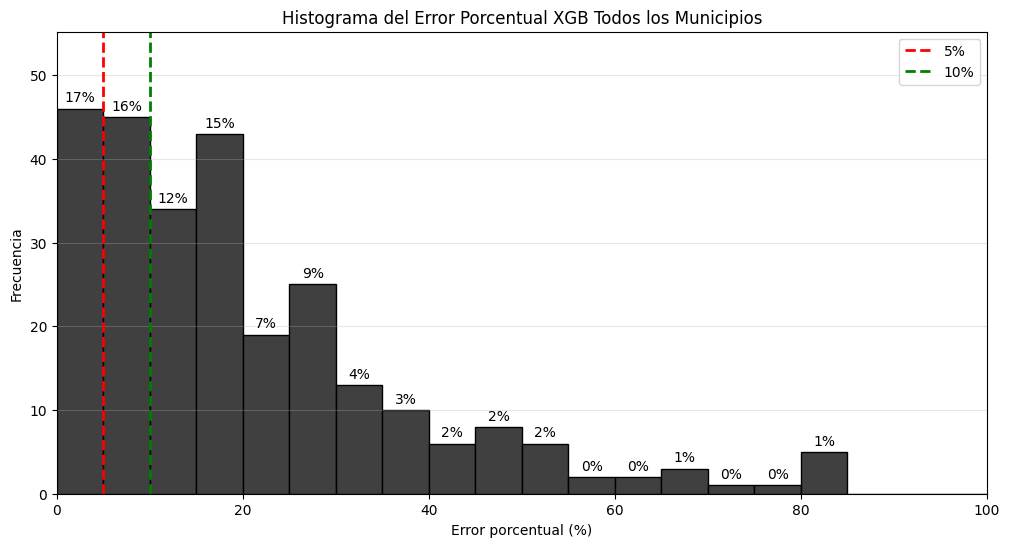

In [53]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_xgb_simple["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual XGB Todos los Municipios")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01   # 2 % del alto máximo

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `xgb_ch`

In [54]:
from scipy import sparse

extra_cols = ["url"]

# Convertir sparse o dense a DataFrame float
if sparse.issparse(X_test_prep_ch):
    X_test_ch_dense = X_test_prep_ch.toarray()
else:
    X_test_ch_dense = X_test_prep_ch

X_test_ch_df = pd.DataFrame(X_test_ch_dense, dtype=float).reset_index(drop=True)

# Resetear y_test
y_test_ch_reset = y_test_ch.reset_index(drop=True)

# Filas originales del test
test_rows_ch = data_ch.loc[test_indices_ch].reset_index(drop=True)

# Evaluación
results_model_xgb_ch = evaluation_table(
    lgbm_ch_simple,
    X_test_ch_df,
    y_test_ch_reset,
    test_rows_ch,
    extra_cols
)

results_model_xgb_ch.head(20)


,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"169,000.00","325,390.13","156,390.13",92.54,https://www.casasymas.com.uy/propiedad/226113-...
1,"420,000.00","658,240.02","238,240.02",56.72,https://www.casasymas.com.uy/propiedad/231704-...
2,"280,000.00","415,783.03","135,783.03",48.49,https://www.casasymas.com.uy/propiedad/91398-c...
3,"125,000.00","179,146.54","54,146.54",43.32,https://www.casasymas.com.uy/propiedad/194189-...
4,"930,000.00","546,399.74","383,600.26",41.25,https://www.casasymas.com.uy/propiedad/158800-...
5,"735,000.00","434,149.40","300,850.60",40.93,https://www.casasymas.com.uy/propiedad/204771-...
6,"130,000.00","179,146.54","49,146.54",37.81,https://www.casasymas.com.uy/propiedad/203660-...
7,"590,000.00","381,372.04","208,627.96",35.36,https://www.casasymas.com.uy/propiedad/173908-...
8,"899,000.00","599,165.69","299,834.31",33.35,https://www.casasymas.com.uy/propiedad/183828-...
9,"147,000.00","191,685.89","44,685.89",30.40,https://www.casasymas.com.uy/propiedad/192090-...


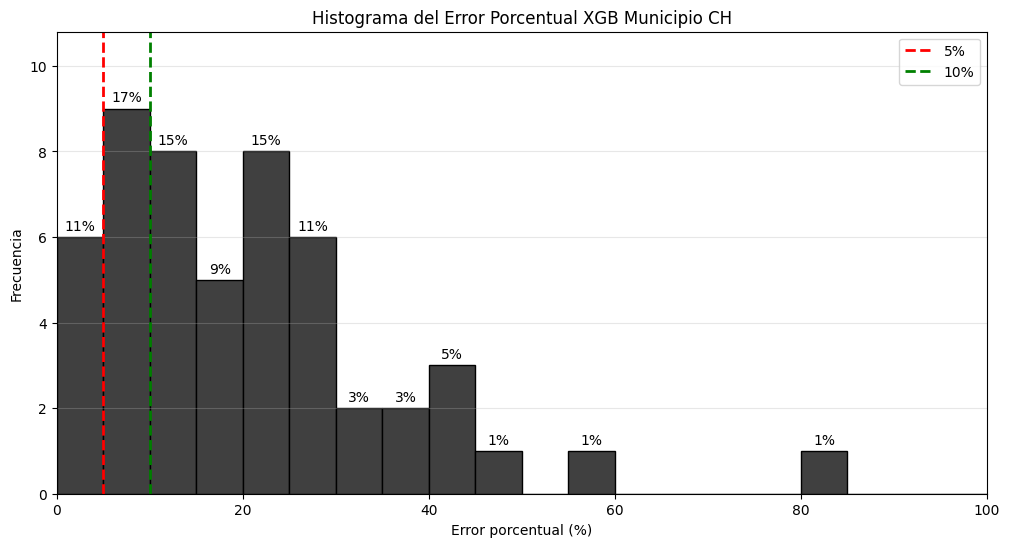

In [55]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_xgb_ch["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual XGB Municipio CH")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01   # 2 % del alto máximo

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `xgb_e`

In [56]:
results_model_xgb_e = evaluation_table(
    xgb_e,
    X_test_prep_e,   # ← NO convertir a DataFrame
    y_test_e.values, # ← log target correcto
    df.loc[test_indices_e],  # ← datos originales
    extra_cols=["url"]
)

results_model_xgb_e.head(20)



,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"135,000.00","245,011.97","110,011.97",81.49,https://www.casasymas.com.uy/propiedad/188669-...
1,"360,000.00","647,452.81","287,452.81",79.85,https://www.casasymas.com.uy/propiedad/191076-...
2,"390,000.00","648,830.56","258,830.56",66.37,https://www.casasymas.com.uy/propiedad/130074-...
3,"600,000.00","973,239.38","373,239.38",62.21,https://www.casasymas.com.uy/propiedad/205390-...
4,"411,000.00","652,999.56","241,999.56",58.88,https://www.casasymas.com.uy/propiedad/187122-...
5,"260,000.00","393,714.72","133,714.72",51.43,https://www.casasymas.com.uy/propiedad/189510-...
6,"770,000.00","1,078,010.62","308,010.63",40.00,https://www.casasymas.com.uy/propiedad/198415-...
7,"1,100,000.00","670,877.44","429,122.56",39.01,https://www.casasymas.com.uy/propiedad/208247-...
8,"1,020,000.00","1,388,817.00","368,817.00",36.16,https://www.casasymas.com.uy/propiedad/71607-c...
9,"499,000.00","325,995.62","173,004.38",34.67,https://www.casasymas.com.uy/propiedad/159640-...


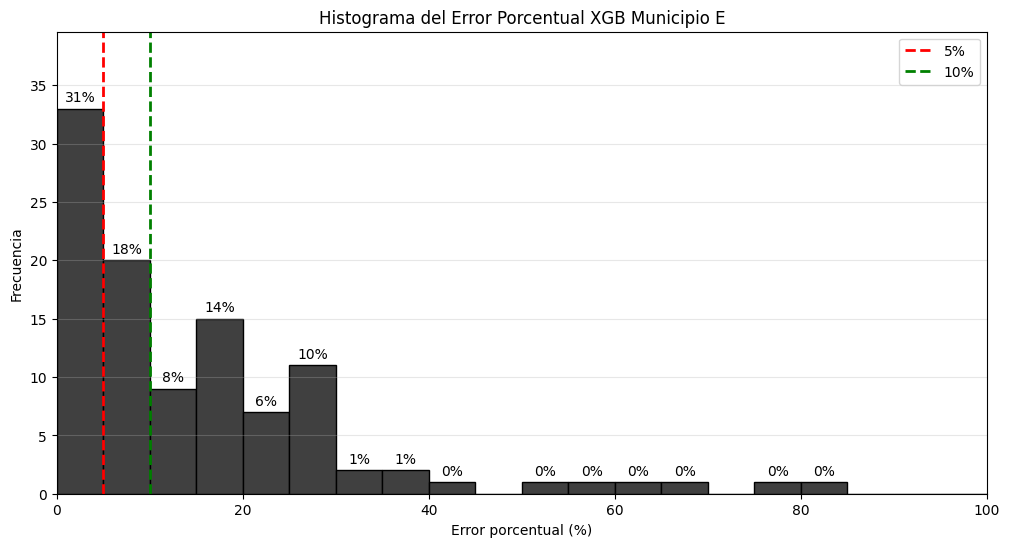

In [57]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_xgb_e["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual XGB Municipio E")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01   # 2 % del alto máximo

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `model_lgbm_simple`

In [58]:
results_model_lgbm_simple = evaluation_table(
    model_lgbm_simple,
    X_test_prep_all_municipios,   # ← NO convertir a DataFrame
    y_test_all_municipios.values, # ← log target correcto
    df.loc[test_indices_all_municipios],  # ← datos originales
    extra_cols=["url"]
)

results_model_lgbm_simple.head(20)

,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"110,000.00","246,083.72","136,083.72",123.71,https://www.casasymas.com.uy/propiedad/191289-...
1,"169,000.00","346,025.08","177,025.08",104.75,https://www.casasymas.com.uy/propiedad/226113-...
2,"75,000.00","145,500.96","70,500.96",94.00,https://www.casasymas.com.uy/propiedad/202559-...
3,"110,000.00","213,018.77","103,018.77",93.65,https://www.casasymas.com.uy/propiedad/211426-...
4,"123,000.00","224,616.49","101,616.49",82.62,https://www.casasymas.com.uy/propiedad/217295-...
5,"129,000.00","228,223.14","99,223.14",76.92,https://www.casasymas.com.uy/propiedad/159112-...
6,"176,000.00","310,826.90","134,826.90",76.61,https://www.casasymas.com.uy/propiedad/182694-...
7,"59,500.00","104,410.05","44,910.05",75.48,https://www.casasymas.com.uy/propiedad/118244-...
8,"170,000.00","296,719.52","126,719.52",74.54,https://www.casasymas.com.uy/propiedad/79935-c...
9,"75,000.00","129,383.58","54,383.58",72.51,https://www.casasymas.com.uy/propiedad/90139-c...


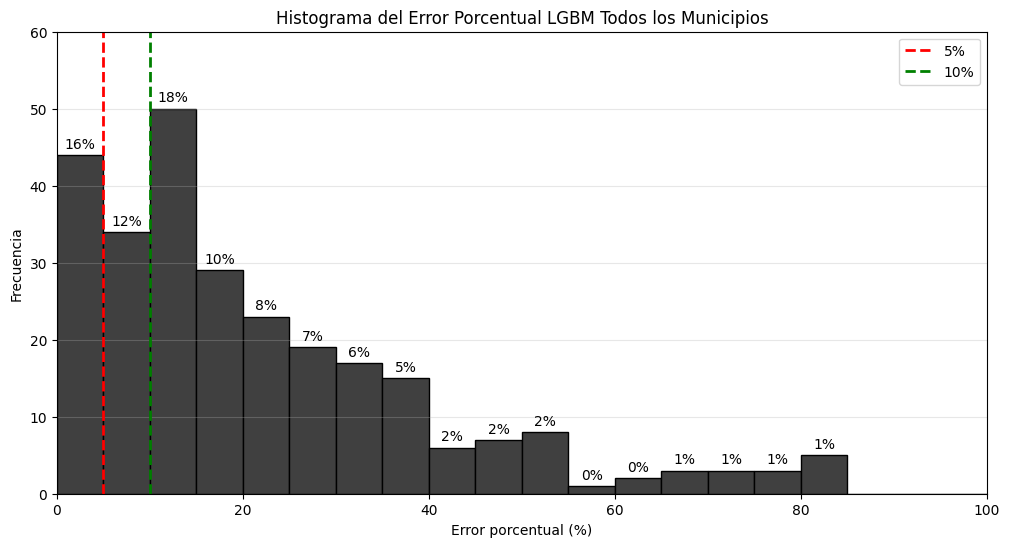

In [59]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_lgbm_simple["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual LGBM Todos los Municipios")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01   # 2 % del alto máximo

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `lgbm_ch_simple`

In [60]:
results_model_lgbm_ch_simple = evaluation_table(
    lgbm_ch_simple,
    X_test_prep_ch,   # ← NO convertir a DataFrame
    y_test_ch.values, # ← log target correcto
    df.loc[test_indices_ch],  # ← datos originales
    extra_cols=["url"]
)

results_model_lgbm_ch_simple.head(20)

,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"169,000.00","325,390.13","156,390.13",92.54,https://www.casasymas.com.uy/propiedad/226113-...
1,"420,000.00","658,240.02","238,240.02",56.72,https://www.casasymas.com.uy/propiedad/231704-...
2,"280,000.00","415,783.03","135,783.03",48.49,https://www.casasymas.com.uy/propiedad/91398-c...
3,"125,000.00","179,146.54","54,146.54",43.32,https://www.casasymas.com.uy/propiedad/194189-...
4,"930,000.00","546,399.74","383,600.26",41.25,https://www.casasymas.com.uy/propiedad/158800-...
5,"735,000.00","434,149.40","300,850.60",40.93,https://www.casasymas.com.uy/propiedad/204771-...
6,"130,000.00","179,146.54","49,146.54",37.81,https://www.casasymas.com.uy/propiedad/203660-...
7,"590,000.00","381,372.04","208,627.96",35.36,https://www.casasymas.com.uy/propiedad/173908-...
8,"899,000.00","599,165.69","299,834.31",33.35,https://www.casasymas.com.uy/propiedad/183828-...
9,"147,000.00","191,685.89","44,685.89",30.40,https://www.casasymas.com.uy/propiedad/192090-...


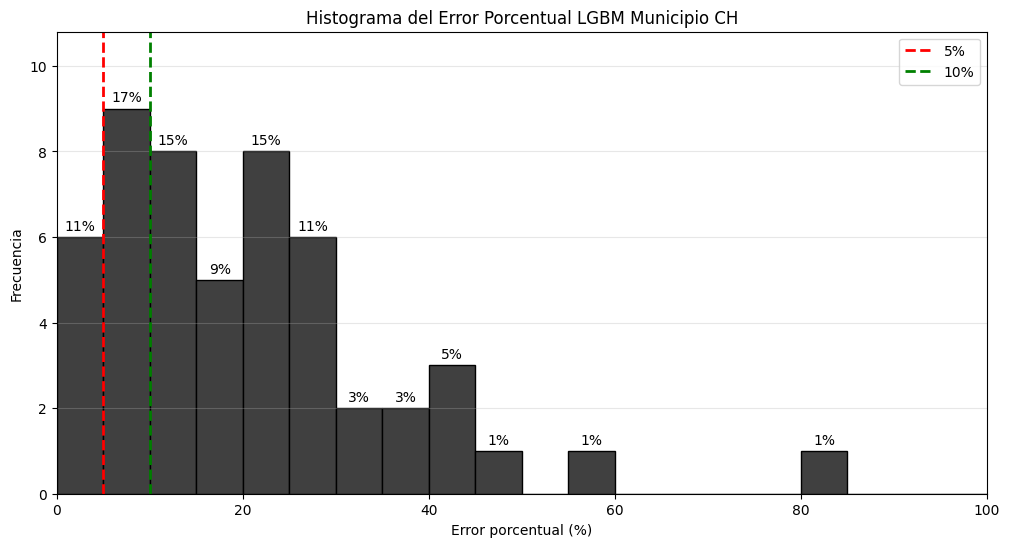

In [61]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_lgbm_ch_simple["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual LGBM Municipio CH")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01   # 2 % del alto máximo

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `lgbm_e_simple`

In [62]:
results_model_lgbm_e_simple = evaluation_table(
    lgbm_e_simple,
    X_test_prep_e,   # ← NO convertir a DataFrame
    y_test_e.values, # ← log target correcto
    df.loc[test_indices_e],  # ← datos originales
    extra_cols=["url"]
)

results_model_lgbm_e_simple.head(20)

,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"360,000.00","708,489.45","348,489.45",96.80,https://www.casasymas.com.uy/propiedad/191076-...
1,"135,000.00","254,653.47","119,653.47",88.63,https://www.casasymas.com.uy/propiedad/188669-...
2,"390,000.00","707,625.98","317,625.98",81.44,https://www.casasymas.com.uy/propiedad/130074-...
3,"199,000.00","352,110.17","153,110.17",76.94,https://www.casasymas.com.uy/propiedad/202921-...
4,"260,000.00","409,605.46","149,605.46",57.54,https://www.casasymas.com.uy/propiedad/189510-...
5,"675,000.00","982,853.49","307,853.49",45.61,https://www.casasymas.com.uy/propiedad/187022-...
6,"1,780,000.00","980,977.72","799,022.28",44.89,https://www.casasymas.com.uy/propiedad/133140-...
7,"411,000.00","592,823.08","181,823.08",44.24,https://www.casasymas.com.uy/propiedad/187122-...
8,"650,000.00","927,174.35","277,174.35",42.64,https://www.casasymas.com.uy/propiedad/208335-...
9,"770,000.00","1,075,782.35","305,782.35",39.71,https://www.casasymas.com.uy/propiedad/198415-...


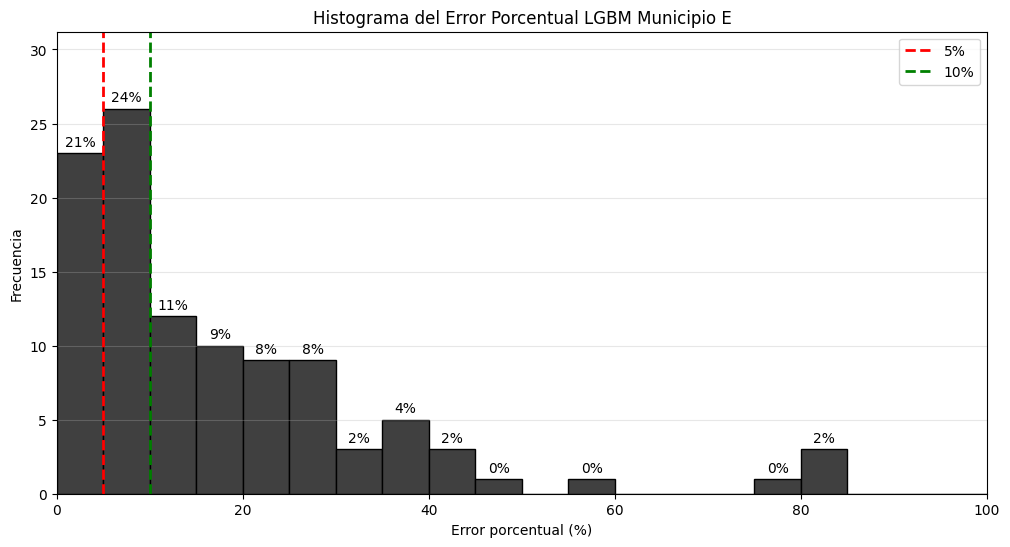

In [63]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_lgbm_e_simple["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual LGBM Municipio E")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01   # 2 % del alto máximo

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `model_lr_simple`

In [64]:
results_model_lr_simple = evaluation_table(
    model_lr_simple,
    X_test_prep_all_municipios,   # ← NO convertir a DataFrame
    y_test_all_municipios.values, # ← log target correcto
    df.loc[test_indices_all_municipios],  # ← datos originales
    extra_cols=["url"]
)

results_model_lr_simple.head(20)

,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"139,900.00","313,208.62","173,308.62",123.88,https://www.casasymas.com.uy/propiedad/168567-...
1,"360,000.00","697,494.19","337,494.19",93.75,https://www.casasymas.com.uy/propiedad/224373-...
2,"176,000.00","340,568.70","164,568.70",93.50,https://www.casasymas.com.uy/propiedad/182694-...
3,"90,000.00","173,275.61","83,275.61",92.53,https://www.casasymas.com.uy/propiedad/123306-...
4,"145,000.00","266,692.13","121,692.13",83.93,https://www.casasymas.com.uy/propiedad/183832-...
5,"75,000.00","136,627.35","61,627.35",82.17,https://www.casasymas.com.uy/propiedad/202559-...
6,"110,000.00","196,545.36","86,545.36",78.68,https://www.casasymas.com.uy/propiedad/191289-...
7,"75,000.00","128,903.63","53,903.63",71.87,https://www.casasymas.com.uy/propiedad/90139-c...
8,"75,000.00","128,903.63","53,903.63",71.87,https://www.casasymas.com.uy/propiedad/90139-o...
9,"260,000.00","445,940.60","185,940.60",71.52,https://www.casasymas.com.uy/propiedad/189510-...


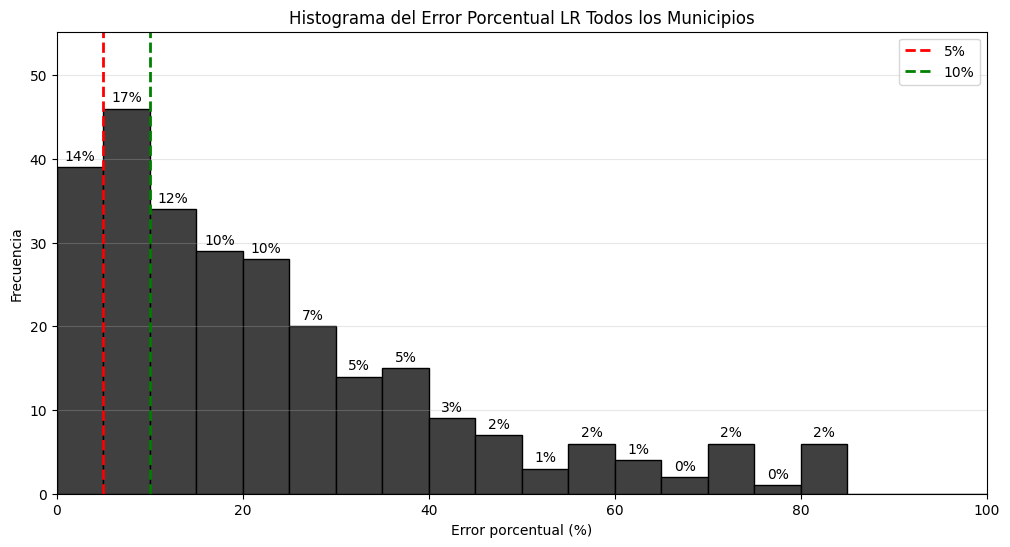

In [65]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_lr_simple["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual LR Todos los Municipios")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01   # 2 % del alto máximo

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `model_lr_ch`

In [66]:
results_model_lr_ch = evaluation_table(
    model_lr_ch,
    X_test_prep_ch,   # ← NO convertir a DataFrame
    y_test_ch.values, # ← log target correcto
    df.loc[test_indices_ch],  # ← datos originales
    extra_cols=["url"]
)

results_model_lr_ch.head(20)

,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"420,000.00","669,184.18","249,184.18",59.33,https://www.casasymas.com.uy/propiedad/231704-...
1,"125,000.00","195,384.92","70,384.92",56.31,https://www.casasymas.com.uy/propiedad/194189-...
2,"169,000.00","257,683.65","88,683.65",52.48,https://www.casasymas.com.uy/propiedad/226113-...
3,"130,000.00","195,384.92","65,384.92",50.30,https://www.casasymas.com.uy/propiedad/203660-...
4,"445,000.00","632,374.89","187,374.89",42.11,https://www.casasymas.com.uy/propiedad/221056-...
5,"430,000.00","277,563.74","152,436.26",35.45,https://www.casasymas.com.uy/propiedad/117827-...
6,"600,000.00","387,903.54","212,096.46",35.35,https://www.casasymas.com.uy/propiedad/150134-...
7,"259,000.00","167,454.71","91,545.29",35.35,https://www.casasymas.com.uy/propiedad/202384-...
8,"450,000.00","294,377.96","155,622.04",34.58,https://www.casasymas.com.uy/propiedad/91043-c...
9,"280,000.00","370,802.53","90,802.53",32.43,https://www.casasymas.com.uy/propiedad/91398-c...


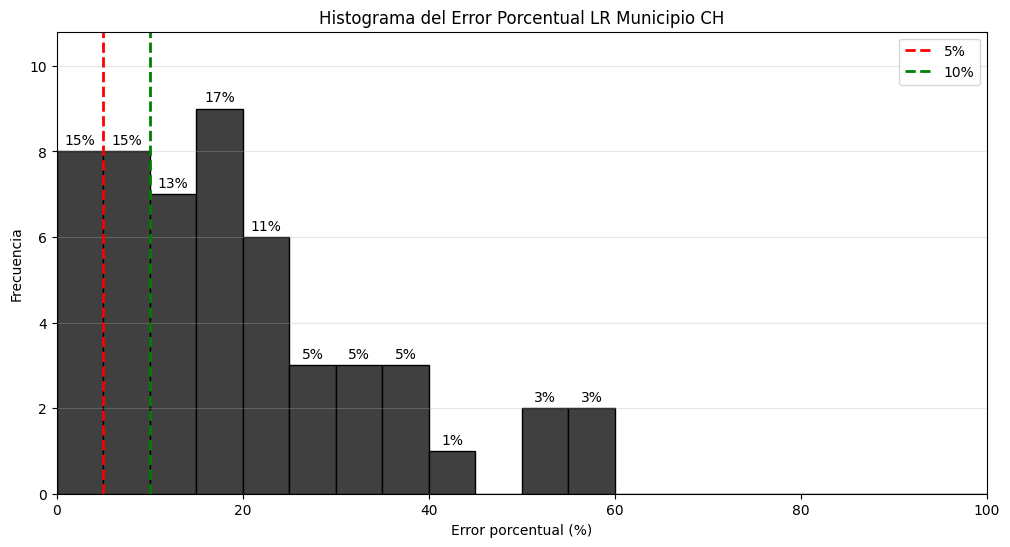

In [67]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_lr_ch["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual LR Municipio CH")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01   # 2 % del alto máximo

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `model_lr_e`

In [68]:
results_model_lr_e = evaluation_table(
    model_lr_e,
    X_test_prep_e,   # ← NO convertir a DataFrame
    y_test_e.values, # ← log target correcto
    df.loc[test_indices_e],  # ← datos originales
    extra_cols=["url"]
)

results_model_lr_e.head(20)

,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"135,000.00","248,997.70","113,997.70",84.44,https://www.casasymas.com.uy/propiedad/188669-...
1,"260,000.00","444,716.45","184,716.45",71.04,https://www.casasymas.com.uy/propiedad/189510-...
2,"360,000.00","613,221.57","253,221.57",70.34,https://www.casasymas.com.uy/propiedad/191076-...
3,"1,020,000.00","1,692,757.66","672,757.66",65.96,https://www.casasymas.com.uy/propiedad/71607-c...
4,"215,000.00","345,180.72","130,180.72",60.55,https://www.casasymas.com.uy/propiedad/159271-...
5,"820,000.00","373,987.88","446,012.12",54.39,https://www.casasymas.com.uy/propiedad/171588-...
6,"770,000.00","1,172,941.50","402,941.50",52.33,https://www.casasymas.com.uy/propiedad/198415-...
7,"1,500,000.00","879,389.83","620,610.17",41.37,https://www.casasymas.com.uy/propiedad/168321-...
8,"1,100,000.00","663,605.42","436,394.58",39.67,https://www.casasymas.com.uy/propiedad/208247-...
9,"580,000.00","808,442.47","228,442.47",39.39,https://www.casasymas.com.uy/propiedad/207735-...


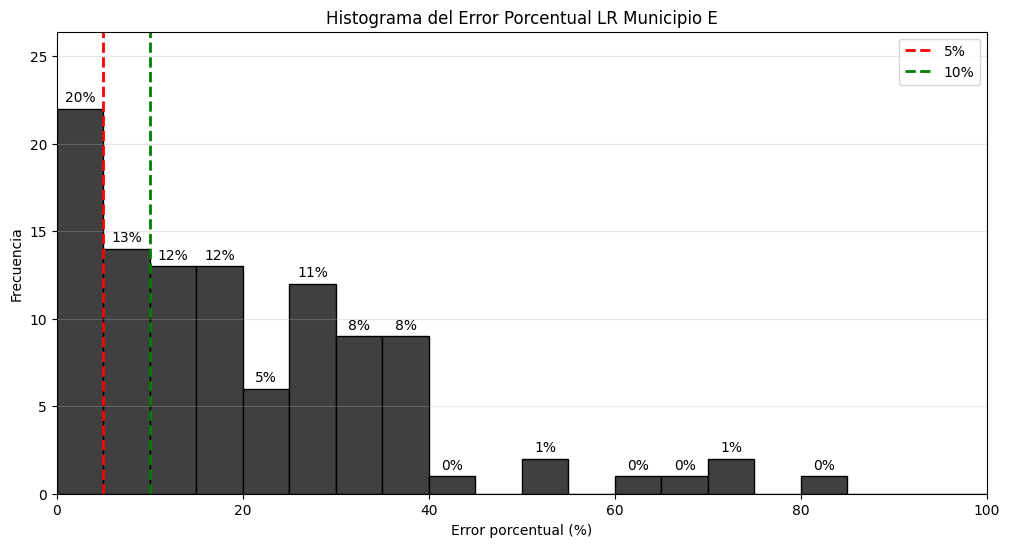

In [69]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_lr_e["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual LR Municipio E")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01   # 2 % del alto máximo

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `rf_all_municipios_simple`

In [70]:
results_model_rf_all_municipios_simple = evaluation_table(
    rf_all_municipios_simple,
    X_test_prep_all_municipios,   # ← NO convertir a DataFrame
    y_test_all_municipios.values, # ← log target correcto
    df.loc[test_indices_all_municipios],  # ← datos originales
    extra_cols=["url"]
)

results_model_rf_all_municipios_simple.head(20)

,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"110,000.00","283,835.91","173,835.91",158.03,https://www.casasymas.com.uy/propiedad/191289-...
1,"75,000.00","177,867.08","102,867.08",137.16,https://www.casasymas.com.uy/propiedad/90139-o...
2,"75,000.00","177,867.08","102,867.08",137.16,https://www.casasymas.com.uy/propiedad/90139-c...
3,"59,500.00","128,801.34","69,301.34",116.47,https://www.casasymas.com.uy/propiedad/118244-...
4,"100,000.00","212,545.31","112,545.31",112.55,https://www.casasymas.com.uy/propiedad/183323-...
5,"75,000.00","151,266.19","76,266.19",101.69,https://www.casasymas.com.uy/propiedad/202559-...
6,"176,000.00","334,886.61","158,886.61",90.28,https://www.casasymas.com.uy/propiedad/182694-...
7,"66,000.00","119,286.59","53,286.59",80.74,https://www.casasymas.com.uy/propiedad/209801-...
8,"72,000.00","129,715.03","57,715.03",80.16,https://www.casasymas.com.uy/propiedad/216798-...
9,"90,000.00","159,270.44","69,270.44",76.97,https://www.casasymas.com.uy/propiedad/123306-...


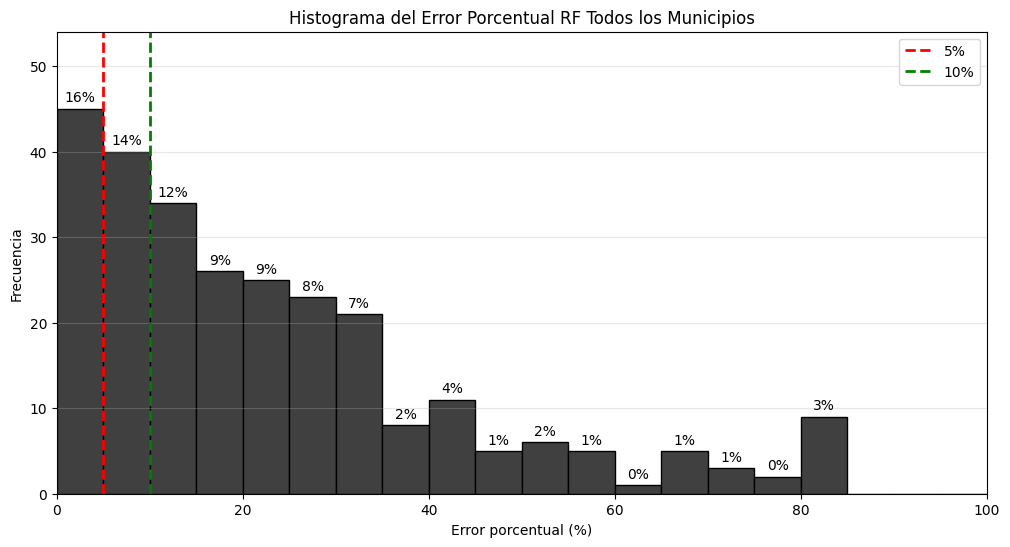

In [71]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_rf_all_municipios_simple["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual RF Todos los Municipios")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01   # 2 % del alto máximo

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `rf_municipios_ch_simple`

In [72]:
results_model_rf_municipio_ch_simple = evaluation_table(
    rf_municipio_ch_simple,
    X_test_prep_ch,   # ← NO convertir a DataFrame
    y_test_ch.values, # ← log target correcto
    df.loc[test_indices_ch],  # ← datos originales
    extra_cols=["url"]
)

results_model_rf_municipio_ch_simple.head(20)

,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"169,000.00","330,775.57","161,775.57",95.73,https://www.casasymas.com.uy/propiedad/226113-...
1,"420,000.00","690,665.98","270,665.98",64.44,https://www.casasymas.com.uy/propiedad/231704-...
2,"180,000.00","253,329.18","73,329.18",40.74,https://www.casasymas.com.uy/propiedad/210725-...
3,"125,000.00","172,558.34","47,558.34",38.05,https://www.casasymas.com.uy/propiedad/194189-...
4,"147,000.00","199,016.35","52,016.35",35.39,https://www.casasymas.com.uy/propiedad/192090-...
5,"930,000.00","605,245.86","324,754.14",34.92,https://www.casasymas.com.uy/propiedad/158800-...
6,"179,900.00","241,961.26","62,061.26",34.50,https://www.casasymas.com.uy/propiedad/191277-...
7,"130,000.00","172,558.34","42,558.34",32.74,https://www.casasymas.com.uy/propiedad/203660-...
8,"899,000.00","620,620.94","278,379.06",30.97,https://www.casasymas.com.uy/propiedad/183828-...
9,"280,000.00","365,214.01","85,214.01",30.43,https://www.casasymas.com.uy/propiedad/91398-c...


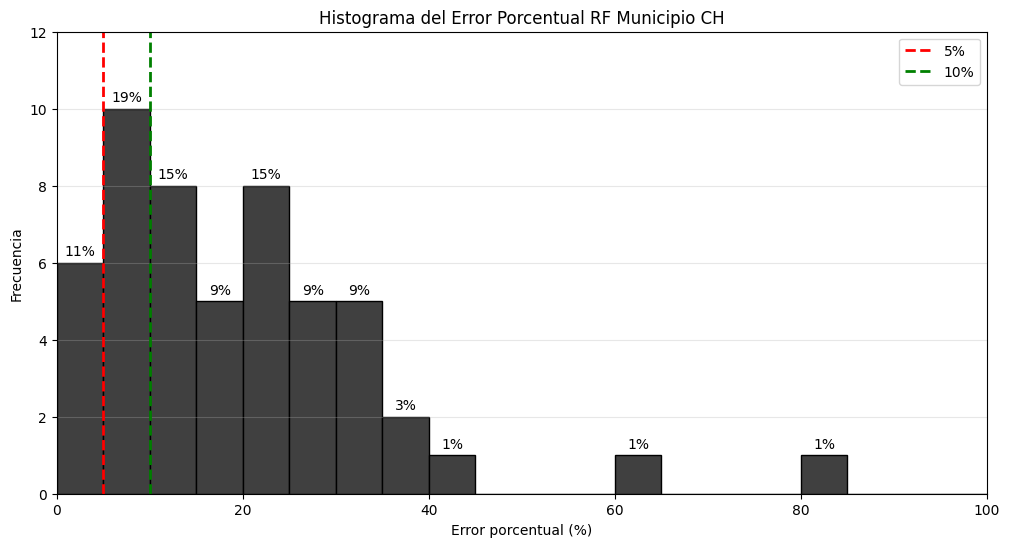

In [73]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_rf_municipio_ch_simple["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual RF Municipio CH")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01   # 2 % del alto máximo

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

### `rf_municipio_e_simple`

In [74]:
results_model_rf_municipio_e_simple = evaluation_table(
    rf_municipio_e_simple,
    X_test_prep_e,   # ← NO convertir a DataFrame
    y_test_e.values, # ← log target correcto
    df.loc[test_indices_e],  # ← datos originales
    extra_cols=["url"]
)

results_model_rf_municipio_e_simple.head(20)

,Precio Real,Precio Predicho,Error Absoluto,Error %,url
0,"135,000.00","284,671.79","149,671.79",110.87,https://www.casasymas.com.uy/propiedad/188669-...
1,"360,000.00","623,034.19","263,034.19",73.07,https://www.casasymas.com.uy/propiedad/191076-...
2,"390,000.00","597,647.54","207,647.54",53.24,https://www.casasymas.com.uy/propiedad/130074-...
3,"1,100,000.00","568,693.32","531,306.68",48.30,https://www.casasymas.com.uy/propiedad/208247-...
4,"260,000.00","374,072.28","114,072.28",43.87,https://www.casasymas.com.uy/propiedad/189510-...
5,"990,000.00","615,037.02","374,962.98",37.88,https://www.casasymas.com.uy/propiedad/230471-...
6,"1,780,000.00","1,118,781.11","661,218.89",37.15,https://www.casasymas.com.uy/propiedad/133140-...
7,"775,000.00","491,559.96","283,440.04",36.57,https://www.casasymas.com.uy/propiedad/178685-...
8,"1,500,000.00","966,248.00","533,752.00",35.58,https://www.casasymas.com.uy/propiedad/168321-...
9,"820,000.00","529,055.23","290,944.77",35.48,https://www.casasymas.com.uy/propiedad/171588-...


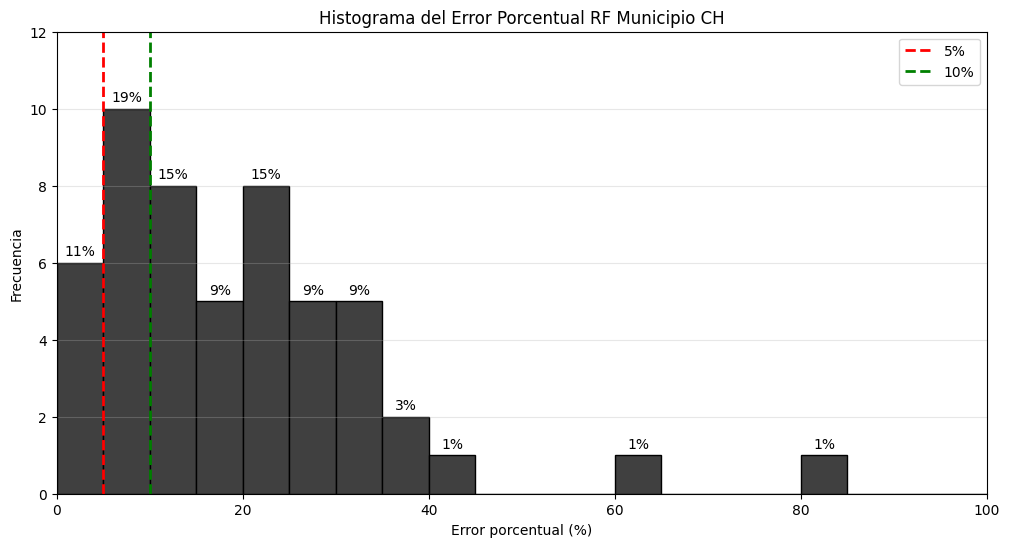

In [75]:
plt.figure(figsize=(12, 6))

# Rango de zoom
zoom_range = results_model_rf_municipio_ch_simple["Error %"].clip(lower=0, upper=80)

# Bins de 5%
bins = np.arange(0, 105, 5)

# Histograma
counts, bins, patches = plt.hist(
    zoom_range,
    bins=bins,
    color="#404040",
    edgecolor="black"
)

plt.title("Histograma del Error Porcentual RF Municipio CH")
plt.xlabel("Error porcentual (%)")
plt.ylabel("Frecuencia")
plt.grid(axis="y", alpha=0.3)

# Líneas verticales
plt.axvline(5, color="red", linestyle="--", linewidth=2, label="5%")
plt.axvline(10, color="green", linestyle="--", linewidth=2, label="10%")
plt.legend()

plt.xlim(0, 100)

# eje mas alejado

ymax = max(counts) * 1.20
plt.ylim(0, ymax)

# Porcentaje sobre cada barra sin decimales y con despegue
total = len(zoom_range)
offset = max(counts) * 0.01   # 2 % del alto máximo

for count, left_edge, right_edge in zip(counts, bins[:-1], bins[1:]):
    if count > 0:
        pct = int((count / total) * 100)
        x = (left_edge + right_edge) / 2
        y = count + offset
        plt.text(
            x,
            y,
            f"{pct}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.show()

## Model Performance 2: relevancia de features

### `xgb_simple`

                       feature  importance
76            cat__municipio_E        0.29
74           cat__municipio_CH        0.13
0                   num__Baños        0.06
23        cat__barrio_carrasco        0.06
59           cat__barrio_prado        0.03
58         cat__barrio_pocitos        0.03
3   num__Superficie Construida        0.03
63     cat__barrio_san-nicolas        0.02
78            cat__municipio_G        0.02
73            cat__municipio_C        0.02
10                num__Piscina        0.02
77            cat__municipio_F        0.02
43    cat__barrio_malvin-norte        0.02
60  cat__barrio_punta-carretas        0.02
47     cat__barrio_nuevo-paris        0.01


<Figure size 800x600 with 0 Axes>

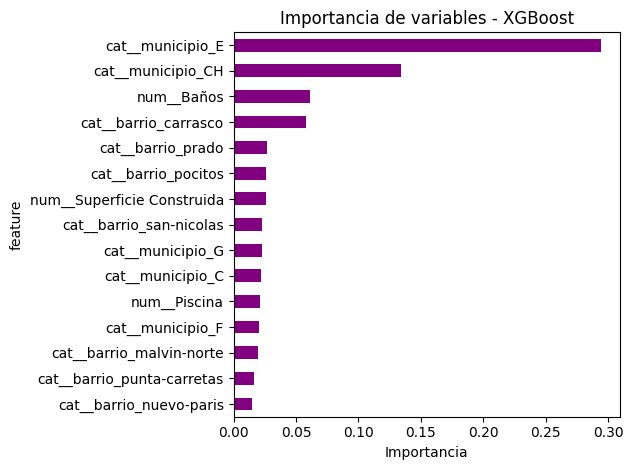

In [76]:
import pandas as pd
import matplotlib.pyplot as plt

# Supongamos que ya tenés tus datos y modelos entrenados
# X_train, y_train, model_rf, model_xgb, model_lgb

# 1) Elegimos un modelo, por ejemplo Random Forest
model = xgb_simple  # o model_xgb, model_lgb

# 2) Extraemos los nombres de las columnas del preprocesador
feature_names = preprocess_all_municipios.get_feature_names_out()

# 3) Obtenemos las importancias
importances = model.feature_importances_

# 4) Creamos un DataFrame ordenado
feat_importances = (
    pd.DataFrame({"feature": feature_names, "importance": importances})
    .sort_values("importance", ascending=False)
)

# 5) Mostramos las 15 variables más importantes
print(feat_importances.head(15))

# 6) (Opcional) gráfico
plt.figure(figsize=(8,6))
feat_importances.head(15).plot(
    kind="barh", x="feature", y="importance", legend=False, color="purple"
)
plt.gca().invert_yaxis()
plt.title("Importancia de variables - XGBoost")
plt.xlabel("Importancia")
plt.tight_layout()
plt.show()

### `xgb_e`

                       feature  importance
15    cat__barrio_malvin-norte        0.20
12        cat__barrio_carrasco        0.13
18     cat__barrio_san-nicolas        0.13
3   num__Superficie Construida        0.10
14          cat__barrio_malvin        0.10
0                   num__Baños        0.09
4      num__Superficie Terreno        0.04
17     cat__barrio_punta-gorda        0.03
1              num__Dormitorio        0.03
10                num__Piscina        0.03
8     num__Año de Construcción        0.02
13  cat__barrio_carrasco-norte        0.02
11                  num__Patio        0.02
16   cat__barrio_parque-rivera        0.01
5                  num__Garage        0.01


<Figure size 800x600 with 0 Axes>

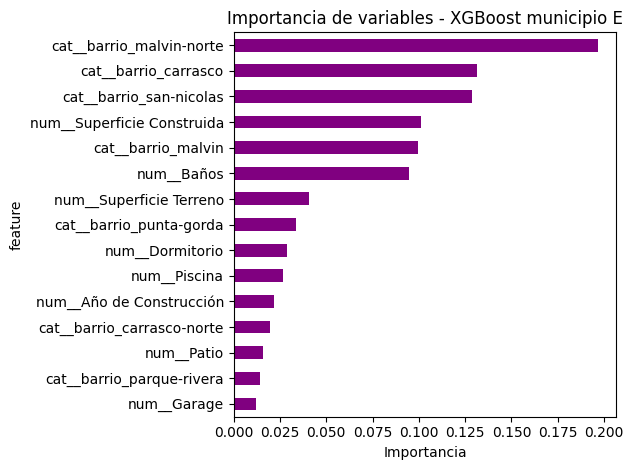

In [77]:
import pandas as pd
import matplotlib.pyplot as plt

# Supongamos que ya tenés tus datos y modelos entrenados
# X_train, y_train, model_rf, model_xgb, model_lgb

# 1) Elegimos un modelo, por ejemplo Random Forest
model = xgb_e  # o model_xgb, model_lgb

# 2) Extraemos los nombres de las columnas del preprocesador
feature_names = preprocess_e.get_feature_names_out()

# 3) Obtengamos las importancias
importances = model.feature_importances_

# 4) Creamos un DataFrame ordenado
feat_importances = (
    pd.DataFrame({"feature": feature_names, "importance": importances})
    .sort_values("importance", ascending=False)
)

# 5) Mostramos las 15 variables más importantes
print(feat_importances.head(15))

# 6) (Opcional) gráfico
plt.figure(figsize=(8,6))
feat_importances.head(15).plot(
    kind="barh", x="feature", y="importance", legend=False, color="purple"
)
plt.gca().invert_yaxis()
plt.title("Importancia de variables - XGBoost municipio E")
plt.xlabel("Importancia")
plt.tight_layout()
plt.show()

### `xgb_ch`

                       feature  importance
3   num__Superficie Construida        0.18
0                   num__Baños        0.15
13   cat__barrio_la-blanqueada        0.13
16  cat__barrio_punta-carretas        0.12
7             num__Calefacción        0.08
5                  num__Garage        0.07
2              num__Superficie        0.04
15         cat__barrio_pocitos        0.04
1              num__Dormitorio        0.03
12           cat__barrio_buceo        0.03
8     num__Año de Construcción        0.02
10                num__Piscina        0.02
6              num__Parrillero        0.02
4      num__Superficie Terreno        0.02
9                  num__Jardín        0.01


<Figure size 800x600 with 0 Axes>

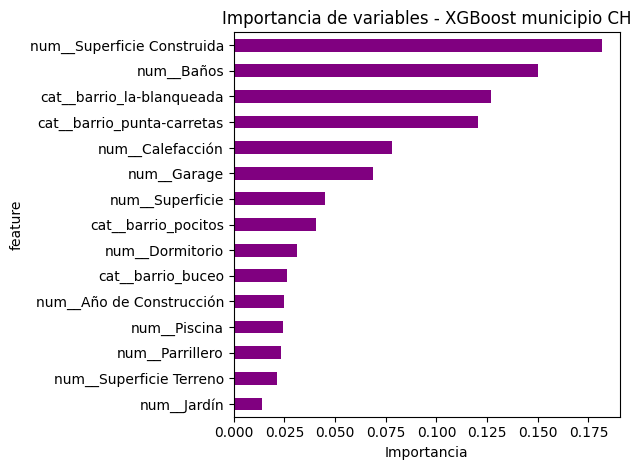

In [78]:
import pandas as pd
import matplotlib.pyplot as plt

# Supongamos que ya tenés tus datos y modelos entrenados
# X_train, y_train, model_rf, model_xgb, model_lgb

# 1) Elegimos un modelo, por ejemplo Random Forest
model = xgb_ch  # o model_xgb, model_lgb

# 2) Extraemos los nombres de las columnas del preprocesador
feature_names = preprocess_ch.get_feature_names_out()

# 3) Obtengamos las importancias
importances = model.feature_importances_

# 4) Creamos un DataFrame ordenado
feat_importances = (
    pd.DataFrame({"feature": feature_names, "importance": importances})
    .sort_values("importance", ascending=False)
)

# 5) Mostramos las 15 variables más importantes
print(feat_importances.head(15))

# 6) (Opcional) gráfico
plt.figure(figsize=(8,6))
feat_importances.head(15).plot(
    kind="barh", x="feature", y="importance", legend=False, color="purple"
)
plt.gca().invert_yaxis()
plt.title("Importancia de variables - XGBoost municipio CH")
plt.xlabel("Importancia")
plt.tight_layout()
plt.show()